# Cell 1: 노트북 개요

## 02_data_collection.ipynb - CARLA 데이터 수집

이 노트북에서는 CARLA 시뮬레이터에서 자율주행 학습용 데이터를 수집합니다.

### 수집 데이터
- **센서**: RGB 카메라 (전방)
- **상태**: 속도, 위치, 방향
- **규칙**: 신호등 상태, 속도 제한
- **액션 (정답)**: steer, throttle, brake (Expert Agent)
- **이벤트**: 충돌, 차선 침범

### 참고 논문
- **CARLA** (Dosovitskiy et al., CoRL 2017): 자율주행 연구용 시뮬레이터
- **End-to-End Learning** (Bojarski et al., 2016): 이미지→조향 직접 학습
- **DAgger** (Ross et al., 2011): Expert demonstration 수집 및 학습

In [1]:
# Cell 1: 라이브러리 및 설정

import sys
import os
import time
import json
import logging
import numpy as np
import pandas as pd
import cv2
import yaml
from pathlib import Path
from datetime import datetime
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# 프로젝트 루트
PROJECT_ROOT = Path().absolute().parent
sys.path.insert(0, str(PROJECT_ROOT))

# 로깅 설정
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# CARLA 임포트
try:
    import carla
    print("✅ CARLA 패키지 로드 성공")
except ImportError:
    print("❌ CARLA 패키지를 설치해주세요: pip install carla==0.9.15")

# 설정 파일 로드
config_path = PROJECT_ROOT / 'config' / 'carla_config.yaml'
with open(config_path, 'r', encoding='utf-8') as f:
    config = yaml.safe_load(f)

print(f"설정 로드 완료: {config_path}")
print(f"수집 설정: {config['collection']['num_episodes']}개 에피소드, 에피소드당 {config['collection']['episode_length']}프레임")

✅ CARLA 패키지 로드 성공
설정 로드 완료: c:\git\automotive\config\carla_config.yaml
수집 설정: 50개 에피소드, 에피소드당 1000프레임


In [2]:
# Cell 2: CARLA 클라이언트 연결

def connect_carla(host='localhost', port=2000, timeout=10.0):
    """CARLA 서버에 연결"""
    try:
        client = carla.Client(host, port)
        client.set_timeout(timeout)
        world = client.get_world()
        logger.info(f"CARLA 연결 성공: {world.get_map().name}")
        return client, world
    except Exception as e:
        logger.error(f"CARLA 연결 실패: {e}")
        return None, None

# 연결
client, world = connect_carla(
    host=config['server']['host'],
    port=config['server']['port'],
    timeout=config['server']['timeout']
)

if world is None:
    raise ConnectionError("❌ CARLA 서버에 연결할 수 없습니다. CarlaUE4.exe가 실행 중인지 확인해주세요.")

# 동기 모드 설정 (데이터 수집에 권장)
settings = world.get_settings()
settings.synchronous_mode = True
settings.fixed_delta_seconds = 1.0 / config['collection']['fps']
world.apply_settings(settings)
print(f"✅ 동기 모드 활성화 (FPS: {config['collection']['fps']})")

2025-12-14 06:33:18,650 - INFO - CARLA 연결 성공: Carla/Maps/Town10HD_Opt


✅ 동기 모드 활성화 (FPS: 10)


In [3]:
# Cell 3: 센서 설정 클래스

class SensorManager:
    """센서 관리 클래스"""
    
    def __init__(self, world, vehicle):
        self.world = world
        self.vehicle = vehicle
        self.sensors = {}
        self.data = {}
        self.blueprint_library = world.get_blueprint_library()
    
    def setup_camera(self, sensor_config):
        """RGB 카메라 설정"""
        camera_bp = self.blueprint_library.find('sensor.camera.rgb')
        camera_bp.set_attribute('image_size_x', str(sensor_config['width']))
        camera_bp.set_attribute('image_size_y', str(sensor_config['height']))
        camera_bp.set_attribute('fov', str(sensor_config['fov']))
        
        pos = sensor_config['position']
        rot = sensor_config.get('rotation', [0, 0, 0])
        transform = carla.Transform(
            carla.Location(x=pos[0], y=pos[1], z=pos[2]),
            carla.Rotation(pitch=rot[0], yaw=rot[1], roll=rot[2])
        )
        
        camera = self.world.spawn_actor(camera_bp, transform, attach_to=self.vehicle)
        camera.listen(lambda image: self._process_camera(image))
        
        self.sensors['rgb_front'] = camera
        logger.info(f"카메라 설정 완료: {sensor_config['width']}x{sensor_config['height']}")
    
    def setup_collision_sensor(self):
        """충돌 센서 설정"""
        collision_bp = self.blueprint_library.find('sensor.other.collision')
        collision_sensor = self.world.spawn_actor(
            collision_bp,
            carla.Transform(),
            attach_to=self.vehicle
        )
        collision_sensor.listen(lambda event: self._process_collision(event))
        self.sensors['collision'] = collision_sensor
        self.data['collision_history'] = []
        logger.info("충돌 센서 설정 완료")
    
    def setup_lane_invasion_sensor(self):
        """차선 침범 센서 설정"""
        lane_bp = self.blueprint_library.find('sensor.other.lane_invasion')
        lane_sensor = self.world.spawn_actor(
            lane_bp,
            carla.Transform(),
            attach_to=self.vehicle
        )
        lane_sensor.listen(lambda event: self._process_lane_invasion(event))
        self.sensors['lane_invasion'] = lane_sensor
        self.data['lane_invasion_history'] = []
        logger.info("차선 침범 센서 설정 완료")
    
    def _process_camera(self, image):
        """카메라 이미지 처리"""
        array = np.frombuffer(image.raw_data, dtype=np.uint8)
        array = array.reshape((image.height, image.width, 4))
        array = array[:, :, :3][:, :, ::-1]  # BGRA -> RGB
        self.data['current_image'] = array
        self.data['image_frame'] = image.frame
    
    def _process_collision(self, event):
        """충돌 이벤트 처리"""
        self.data['collision_history'].append({
            'frame': event.frame,
            'actor': event.other_actor.type_id if event.other_actor else 'unknown',
            'intensity': event.normal_impulse.length()
        })
    
    def _process_lane_invasion(self, event):
        """차선 침범 이벤트 처리"""
        self.data['lane_invasion_history'].append({
            'frame': event.frame,
            'lane_types': [str(x) for x in event.crossed_lane_markings]
        })
    
    def get_current_image(self):
        """현재 이미지 반환"""
        return self.data.get('current_image')
    
    def check_collision(self, frame):
        """해당 프레임에서 충돌 여부 확인"""
        for col in self.data.get('collision_history', []):
            if col['frame'] == frame:
                return True
        return False
    
    def check_lane_invasion(self, frame):
        """해당 프레임에서 차선 침범 여부 확인"""
        for lane in self.data.get('lane_invasion_history', []):
            if lane['frame'] == frame:
                return True
        return False
    
    def reset_events(self):
        """이벤트 기록 초기화"""
        self.data['collision_history'] = []
        self.data['lane_invasion_history'] = []
    
    def destroy(self):
        """모든 센서 삭제"""
        for name, sensor in self.sensors.items():
            if sensor is not None:
                sensor.stop()
                sensor.destroy()
        self.sensors = {}
        logger.info("센서 정리 완료")

print("✅ SensorManager 클래스 정의 완료")

✅ SensorManager 클래스 정의 완료


In [4]:
# Cell 4: 데이터 수집기 클래스

class DataCollector:
    """CARLA 데이터 수집기"""
    
    def __init__(self, world, save_dir):
        self.world = world
        self.save_dir = Path(save_dir)
        self.save_dir.mkdir(parents=True, exist_ok=True)
        
        self.vehicle = None
        self.sensor_manager = None
        self.current_episode = 0
        self.frames = []
        self.images = []
        
        # 블루프린트
        self.blueprint_library = world.get_blueprint_library()
        self.spawn_points = world.get_map().get_spawn_points()
    
    def spawn_vehicle(self, blueprint_name='vehicle.tesla.model3'):
        """차량 스폰"""
        vehicle_bp = self.blueprint_library.find(blueprint_name)
        spawn_point = np.random.choice(self.spawn_points)
        
        self.vehicle = self.world.spawn_actor(vehicle_bp, spawn_point)
        logger.info(f"차량 스폰: {blueprint_name}")
        return self.vehicle
    
    def setup_sensors(self, sensor_config):
        """센서 설정"""
        self.sensor_manager = SensorManager(self.world, self.vehicle)
        self.sensor_manager.setup_camera(sensor_config)
        self.sensor_manager.setup_collision_sensor()
        self.sensor_manager.setup_lane_invasion_sensor()
    
    def get_vehicle_state(self):
        """차량 상태 정보 수집"""
        # 위치 및 방향
        transform = self.vehicle.get_transform()
        location = transform.location
        rotation = transform.rotation
        
        # 속도
        velocity = self.vehicle.get_velocity()
        speed = np.sqrt(velocity.x**2 + velocity.y**2 + velocity.z**2)
        
        # 컨트롤 (Expert action)
        control = self.vehicle.get_control()
        
        # 신호등
        traffic_light = 'none'
        if self.vehicle.is_at_traffic_light():
            tl = self.vehicle.get_traffic_light()
            state = tl.get_state()
            if state == carla.TrafficLightState.Red:
                traffic_light = 'red'
            elif state == carla.TrafficLightState.Yellow:
                traffic_light = 'yellow'
            elif state == carla.TrafficLightState.Green:
                traffic_light = 'green'
        
        # 속도 제한 (맵에서 가져오기 - 간소화)
        speed_limit = 50.0  # 기본값 km/h
        
        return {
            'ego_speed': speed,
            'ego_location': [location.x, location.y, location.z],
            'ego_rotation': [rotation.pitch, rotation.yaw, rotation.roll],
            'traffic_light': traffic_light,
            'speed_limit': speed_limit,
            'steer': control.steer,
            'throttle': control.throttle,
            'brake': control.brake
        }
    
    def collect_frame(self, frame_id):
        """단일 프레임 수집"""
        # 월드 틱 (동기 모드)
        world_frame = self.world.tick()
        
        # 약간 대기 (센서 데이터 수신)
        time.sleep(0.05)
        
        # 이미지
        image = self.sensor_manager.get_current_image()
        if image is None:
            return None
        
        # 상태
        state = self.get_vehicle_state()
        
        # 이벤트
        collision = self.sensor_manager.check_collision(world_frame)
        lane_invasion = self.sensor_manager.check_lane_invasion(world_frame)
        
        # 프레임 데이터
        frame_data = {
            'frame_id': frame_id,
            'world_frame': world_frame,
            'collision': collision,
            'lane_invasion': lane_invasion,
            **state
        }
        
        self.frames.append(frame_data)
        self.images.append(image.copy())
        
        return frame_data
    
    def run_episode(self, episode_length, enable_autopilot=True):
        """에피소드 실행"""
        self.frames = []
        self.images = []
        self.sensor_manager.reset_events()
        
        # Autopilot 활성화
        if enable_autopilot:
            self.vehicle.set_autopilot(True)
        
        # 안정화 대기
        for _ in range(10):
            self.world.tick()
        time.sleep(0.5)
        
        # 데이터 수집
        collision_count = 0
        for frame_id in tqdm(range(episode_length), desc=f"Episode {self.current_episode}"):
            frame_data = self.collect_frame(frame_id)
            
            if frame_data is None:
                continue
            
            # 충돌 시 카운트
            if frame_data['collision']:
                collision_count += 1
                if collision_count > 3:  # 3번 이상 충돌 시 에피소드 종료
                    logger.warning("다중 충돌로 에피소드 조기 종료")
                    break
        
        # Autopilot 비활성화
        self.vehicle.set_autopilot(False)
        
        return len(self.frames)
    
    def save_episode(self):
        """에피소드 저장"""
        episode_dir = self.save_dir / f"episode_{self.current_episode:03d}"
        episode_dir.mkdir(exist_ok=True)
        
        # 이미지 저장
        image_dir = episode_dir / 'images'
        image_dir.mkdir(exist_ok=True)
        
        for i, (frame, image) in enumerate(zip(self.frames, self.images)):
            image_path = image_dir / f"{i:06d}.jpg"
            cv2.imwrite(str(image_path), cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
            frame['image_path'] = str(image_path)
        
        # 메타데이터 저장
        df = pd.DataFrame(self.frames)
        df.to_parquet(episode_dir / 'frames.parquet', index=False)
        
        # 에피소드 정보
        episode_info = {
            'episode_id': self.current_episode,
            'num_frames': len(self.frames),
            'total_collisions': sum(1 for f in self.frames if f['collision']),
            'total_lane_invasions': sum(1 for f in self.frames if f['lane_invasion']),
            'timestamp': datetime.now().isoformat()
        }
        
        with open(episode_dir / 'metadata.json', 'w') as f:
            json.dump(episode_info, f, indent=2)
        
        logger.info(f"에피소드 {self.current_episode} 저장 완료: {len(self.frames)} 프레임")
        self.current_episode += 1
        
        return episode_info
    
    def reset(self):
        """에피소드 리셋 (차량 재스폰)"""
        # 기존 액터 삭제
        if self.sensor_manager:
            self.sensor_manager.destroy()
        if self.vehicle:
            self.vehicle.destroy()
        
        # 잠시 대기
        time.sleep(0.5)
    
    def cleanup(self):
        """완전 정리"""
        self.reset()
        logger.info("데이터 수집기 정리 완료")

print("✅ DataCollector 클래스 정의 완료")

✅ DataCollector 클래스 정의 완료


In [5]:
# Cell 5: 수집 실행 설정

# 저장 디렉토리
SAVE_DIR = PROJECT_ROOT / 'dataset' / 'carla_collected'
print(f"저장 디렉토리: {SAVE_DIR}")

# 수집 설정
NUM_EPISODES = config['collection']['num_episodes']  # 50
EPISODE_LENGTH = config['collection']['episode_length']  # 1000
SENSOR_CONFIG = config['sensors']['rgb_front']

print(f"\n수집 설정:")
print(f"  - 에피소드 수: {NUM_EPISODES}")
print(f"  - 에피소드당 프레임: {EPISODE_LENGTH}")
print(f"  - 예상 총 프레임: {NUM_EPISODES * EPISODE_LENGTH:,}")
print(f"  - 카메라 해상도: {SENSOR_CONFIG['width']}x{SENSOR_CONFIG['height']}")

저장 디렉토리: c:\git\automotive\dataset\carla_collected

수집 설정:
  - 에피소드 수: 50
  - 에피소드당 프레임: 1000
  - 예상 총 프레임: 50,000
  - 카메라 해상도: 800x600


In [6]:
# Cell 6: 데이터 수집 실행

if world is None:
    raise RuntimeError("CARLA world가 연결되지 않았습니다. Cell 2를 다시 실행해주세요.")

# 데이터 수집기 생성
collector = DataCollector(world, SAVE_DIR)

# 수집 통계
all_episodes_info = []

try:
    for ep in range(NUM_EPISODES):
        print(f"\n{'='*50}")
        print(f"에피소드 {ep + 1}/{NUM_EPISODES} 시작")
        print(f"{'='*50}")
        
        # 차량 스폰
        collector.spawn_vehicle()
        
        # 센서 설정
        collector.setup_sensors(SENSOR_CONFIG)
        
        # 에피소드 실행
        num_frames = collector.run_episode(EPISODE_LENGTH)
        
        # 저장
        episode_info = collector.save_episode()
        all_episodes_info.append(episode_info)
        
        # 리셋
        collector.reset()
        
        print(f"\n✅ 에피소드 {ep + 1} 완료:")
        print(f"   - 수집 프레임: {num_frames}")
        print(f"   - 충돌: {episode_info['total_collisions']}회")
        print(f"   - 차선 침범: {episode_info['total_lane_invasions']}회")

except KeyboardInterrupt:
    print("\n\n⚠️ 사용자에 의해 중단됨")

finally:
    collector.cleanup()
    
    # 동기 모드 해제
    if world:
        settings = world.get_settings()
        settings.synchronous_mode = False
        world.apply_settings(settings)

print(f"\n\n{'='*50}")
print("데이터 수집 완료!")
print(f"총 {len(all_episodes_info)}개 에피소드 수집")

2025-12-14 06:33:18,899 - INFO - 차량 스폰: vehicle.tesla.model3
2025-12-14 06:33:18,916 - INFO - 카메라 설정 완료: 800x600



에피소드 1/50 시작


2025-12-14 06:33:18,956 - INFO - 충돌 센서 설정 완료
2025-12-14 06:33:18,982 - INFO - 차선 침범 센서 설정 완료


Episode 0:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-12-14 06:34:21,815 - INFO - 에피소드 0 저장 완료: 1000 프레임
2025-12-14 06:34:21,817 - INFO - 센서 정리 완료
2025-12-14 06:34:22,322 - INFO - 차량 스폰: vehicle.tesla.model3
2025-12-14 06:34:22,327 - INFO - 카메라 설정 완료: 800x600
2025-12-14 06:34:22,329 - INFO - 충돌 센서 설정 완료
2025-12-14 06:34:22,330 - INFO - 차선 침범 센서 설정 완료



✅ 에피소드 1 완료:
   - 수집 프레임: 1000
   - 충돌: 0회
   - 차선 침범: 0회

에피소드 2/50 시작


Episode 1:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-12-14 06:35:22,050 - INFO - 에피소드 1 저장 완료: 1000 프레임
2025-12-14 06:35:22,053 - INFO - 센서 정리 완료
2025-12-14 06:35:22,558 - INFO - 차량 스폰: vehicle.tesla.model3
2025-12-14 06:35:22,564 - INFO - 카메라 설정 완료: 800x600
2025-12-14 06:35:22,566 - INFO - 충돌 센서 설정 완료
2025-12-14 06:35:22,567 - INFO - 차선 침범 센서 설정 완료



✅ 에피소드 2 완료:
   - 수집 프레임: 1000
   - 충돌: 0회
   - 차선 침범: 0회

에피소드 3/50 시작


Episode 2:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-12-14 06:36:21,567 - INFO - 에피소드 2 저장 완료: 1000 프레임
2025-12-14 06:36:21,568 - INFO - 센서 정리 완료
2025-12-14 06:36:22,074 - INFO - 차량 스폰: vehicle.tesla.model3
2025-12-14 06:36:22,079 - INFO - 카메라 설정 완료: 800x600
2025-12-14 06:36:22,081 - INFO - 충돌 센서 설정 완료
2025-12-14 06:36:22,082 - INFO - 차선 침범 센서 설정 완료



✅ 에피소드 3 완료:
   - 수집 프레임: 1000
   - 충돌: 0회
   - 차선 침범: 0회

에피소드 4/50 시작


Episode 3:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-12-14 06:37:20,439 - INFO - 에피소드 3 저장 완료: 1000 프레임
2025-12-14 06:37:20,440 - INFO - 센서 정리 완료
2025-12-14 06:37:20,945 - INFO - 차량 스폰: vehicle.tesla.model3
2025-12-14 06:37:20,950 - INFO - 카메라 설정 완료: 800x600
2025-12-14 06:37:20,952 - INFO - 충돌 센서 설정 완료
2025-12-14 06:37:20,954 - INFO - 차선 침범 센서 설정 완료



✅ 에피소드 4 완료:
   - 수집 프레임: 1000
   - 충돌: 0회
   - 차선 침범: 0회

에피소드 5/50 시작


Episode 4:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-12-14 06:38:19,214 - INFO - 에피소드 4 저장 완료: 1000 프레임
2025-12-14 06:38:19,217 - INFO - 센서 정리 완료
2025-12-14 06:38:19,722 - INFO - 차량 스폰: vehicle.tesla.model3
2025-12-14 06:38:19,727 - INFO - 카메라 설정 완료: 800x600
2025-12-14 06:38:19,728 - INFO - 충돌 센서 설정 완료
2025-12-14 06:38:19,730 - INFO - 차선 침범 센서 설정 완료



✅ 에피소드 5 완료:
   - 수집 프레임: 1000
   - 충돌: 0회
   - 차선 침범: 0회

에피소드 6/50 시작


Episode 5:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-12-14 06:39:17,880 - INFO - 에피소드 5 저장 완료: 1000 프레임
2025-12-14 06:39:17,882 - INFO - 센서 정리 완료
2025-12-14 06:39:18,388 - INFO - 차량 스폰: vehicle.tesla.model3
2025-12-14 06:39:18,392 - INFO - 카메라 설정 완료: 800x600
2025-12-14 06:39:18,394 - INFO - 충돌 센서 설정 완료
2025-12-14 06:39:18,395 - INFO - 차선 침범 센서 설정 완료



✅ 에피소드 6 완료:
   - 수집 프레임: 1000
   - 충돌: 0회
   - 차선 침범: 0회

에피소드 7/50 시작


Episode 6:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-12-14 06:40:16,658 - INFO - 에피소드 6 저장 완료: 1000 프레임
2025-12-14 06:40:16,660 - INFO - 센서 정리 완료
2025-12-14 06:40:17,164 - INFO - 차량 스폰: vehicle.tesla.model3
2025-12-14 06:40:17,169 - INFO - 카메라 설정 완료: 800x600
2025-12-14 06:40:17,171 - INFO - 충돌 센서 설정 완료
2025-12-14 06:40:17,172 - INFO - 차선 침범 센서 설정 완료



✅ 에피소드 7 완료:
   - 수집 프레임: 1000
   - 충돌: 0회
   - 차선 침범: 0회

에피소드 8/50 시작


Episode 7:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-12-14 06:41:15,324 - INFO - 에피소드 7 저장 완료: 1000 프레임
2025-12-14 06:41:15,327 - INFO - 센서 정리 완료
2025-12-14 06:41:15,831 - INFO - 차량 스폰: vehicle.tesla.model3
2025-12-14 06:41:15,836 - INFO - 카메라 설정 완료: 800x600
2025-12-14 06:41:15,838 - INFO - 충돌 센서 설정 완료
2025-12-14 06:41:15,840 - INFO - 차선 침범 센서 설정 완료



✅ 에피소드 8 완료:
   - 수집 프레임: 1000
   - 충돌: 0회
   - 차선 침범: 0회

에피소드 9/50 시작


Episode 8:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-12-14 06:42:13,953 - INFO - 에피소드 8 저장 완료: 1000 프레임
2025-12-14 06:42:13,955 - INFO - 센서 정리 완료
2025-12-14 06:42:14,459 - INFO - 차량 스폰: vehicle.tesla.model3
2025-12-14 06:42:14,465 - INFO - 카메라 설정 완료: 800x600
2025-12-14 06:42:14,466 - INFO - 충돌 센서 설정 완료
2025-12-14 06:42:14,468 - INFO - 차선 침범 센서 설정 완료



✅ 에피소드 9 완료:
   - 수집 프레임: 1000
   - 충돌: 0회
   - 차선 침범: 0회

에피소드 10/50 시작


Episode 9:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-12-14 06:43:12,929 - INFO - 에피소드 9 저장 완료: 1000 프레임
2025-12-14 06:43:12,931 - INFO - 센서 정리 완료
2025-12-14 06:43:13,437 - INFO - 차량 스폰: vehicle.tesla.model3
2025-12-14 06:43:13,442 - INFO - 카메라 설정 완료: 800x600
2025-12-14 06:43:13,444 - INFO - 충돌 센서 설정 완료
2025-12-14 06:43:13,445 - INFO - 차선 침범 센서 설정 완료



✅ 에피소드 10 완료:
   - 수집 프레임: 1000
   - 충돌: 0회
   - 차선 침범: 0회

에피소드 11/50 시작


Episode 10:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-12-14 06:44:11,791 - INFO - 에피소드 10 저장 완료: 1000 프레임
2025-12-14 06:44:11,793 - INFO - 센서 정리 완료
2025-12-14 06:44:12,299 - INFO - 차량 스폰: vehicle.tesla.model3
2025-12-14 06:44:12,305 - INFO - 카메라 설정 완료: 800x600
2025-12-14 06:44:12,306 - INFO - 충돌 센서 설정 완료
2025-12-14 06:44:12,307 - INFO - 차선 침범 센서 설정 완료



✅ 에피소드 11 완료:
   - 수집 프레임: 1000
   - 충돌: 0회
   - 차선 침범: 0회

에피소드 12/50 시작


Episode 11:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-12-14 06:45:10,414 - INFO - 에피소드 11 저장 완료: 1000 프레임
2025-12-14 06:45:10,416 - INFO - 센서 정리 완료
2025-12-14 06:45:10,922 - INFO - 차량 스폰: vehicle.tesla.model3
2025-12-14 06:45:10,927 - INFO - 카메라 설정 완료: 800x600
2025-12-14 06:45:10,929 - INFO - 충돌 센서 설정 완료
2025-12-14 06:45:10,931 - INFO - 차선 침범 센서 설정 완료



✅ 에피소드 12 완료:
   - 수집 프레임: 1000
   - 충돌: 0회
   - 차선 침범: 0회

에피소드 13/50 시작


Episode 12:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-12-14 06:46:09,734 - INFO - 에피소드 12 저장 완료: 1000 프레임
2025-12-14 06:46:09,736 - INFO - 센서 정리 완료
2025-12-14 06:46:10,242 - INFO - 차량 스폰: vehicle.tesla.model3
2025-12-14 06:46:10,248 - INFO - 카메라 설정 완료: 800x600
2025-12-14 06:46:10,250 - INFO - 충돌 센서 설정 완료
2025-12-14 06:46:10,252 - INFO - 차선 침범 센서 설정 완료



✅ 에피소드 13 완료:
   - 수집 프레임: 1000
   - 충돌: 0회
   - 차선 침범: 0회

에피소드 14/50 시작


Episode 13:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-12-14 06:47:08,482 - INFO - 에피소드 13 저장 완료: 1000 프레임
2025-12-14 06:47:08,485 - INFO - 센서 정리 완료
2025-12-14 06:47:08,989 - INFO - 차량 스폰: vehicle.tesla.model3
2025-12-14 06:47:08,995 - INFO - 카메라 설정 완료: 800x600
2025-12-14 06:47:08,997 - INFO - 충돌 센서 설정 완료
2025-12-14 06:47:08,998 - INFO - 차선 침범 센서 설정 완료



✅ 에피소드 14 완료:
   - 수집 프레임: 1000
   - 충돌: 0회
   - 차선 침범: 0회

에피소드 15/50 시작


Episode 14:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-12-14 06:47:16,204 - INFO - 센서 정리 완료




⚠️ 사용자에 의해 중단됨


2025-12-14 06:47:16,708 - INFO - 데이터 수집기 정리 완료




데이터 수집 완료!
총 14개 에피소드 수집


In [7]:
# Cell 7: 수집 데이터 검증 및 시각화

import glob

# 수집된 에피소드 확인
episode_dirs = sorted(glob.glob(str(SAVE_DIR / 'episode_*')))
print(f"수집된 에피소드: {len(episode_dirs)}개\n")

# 통계 수집
total_frames = 0
total_collisions = 0
total_lane_invasions = 0

for ep_dir in episode_dirs:
    metadata_path = Path(ep_dir) / 'metadata.json'
    if metadata_path.exists():
        with open(metadata_path, 'r') as f:
            info = json.load(f)
        total_frames += info['num_frames']
        total_collisions += info['total_collisions']
        total_lane_invasions += info['total_lane_invasions']

print(f"총 프레임: {total_frames:,}")
print(f"총 충돌: {total_collisions}회")
print(f"총 차선 침범: {total_lane_invasions}회")
print(f"충돌률: {total_collisions / total_frames * 100:.2f}%" if total_frames > 0 else "")

수집된 에피소드: 14개

총 프레임: 14,000
총 충돌: 0회
총 차선 침범: 0회
충돌률: 0.00%


에피소드 데이터 shape: (1000, 13)

컬럼: ['frame_id', 'world_frame', 'collision', 'lane_invasion', 'ego_speed', 'ego_location', 'ego_rotation', 'traffic_light', 'speed_limit', 'steer', 'throttle', 'brake', 'image_path']


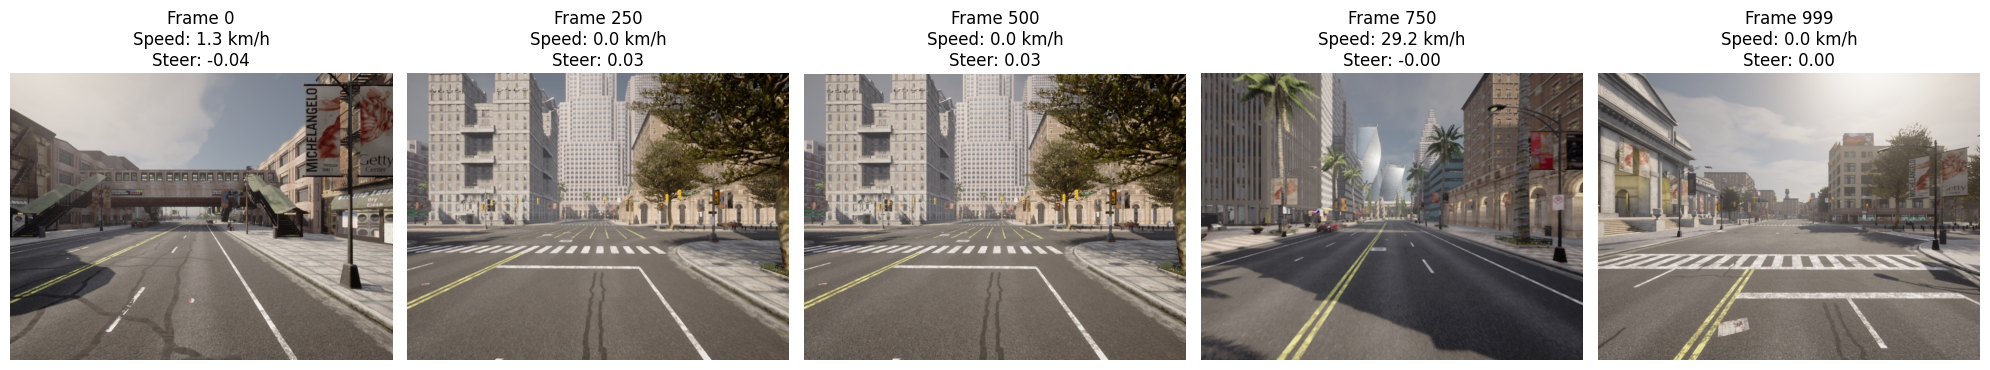

In [8]:
# Cell 8: 샘플 이미지 시각화

# 첫 번째 에피소드에서 샘플 이미지 로드
if episode_dirs:
    sample_ep = Path(episode_dirs[0])
    
    # 프레임 데이터 로드
    df = pd.read_parquet(sample_ep / 'frames.parquet')
    print(f"에피소드 데이터 shape: {df.shape}")
    print(f"\n컬럼: {list(df.columns)}")
    
    # 샘플 이미지 표시
    sample_indices = [0, len(df)//4, len(df)//2, 3*len(df)//4, len(df)-1]
    
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    
    for ax, idx in zip(axes, sample_indices):
        if idx < len(df):
            image_path = df.iloc[idx]['image_path']
            if os.path.exists(image_path):
                img = cv2.imread(image_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                ax.imshow(img)
                
                speed = df.iloc[idx]['ego_speed'] * 3.6  # m/s -> km/h
                steer = df.iloc[idx]['steer']
                ax.set_title(f"Frame {idx}\nSpeed: {speed:.1f} km/h\nSteer: {steer:.2f}")
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("수집된 에피소드가 없습니다.")

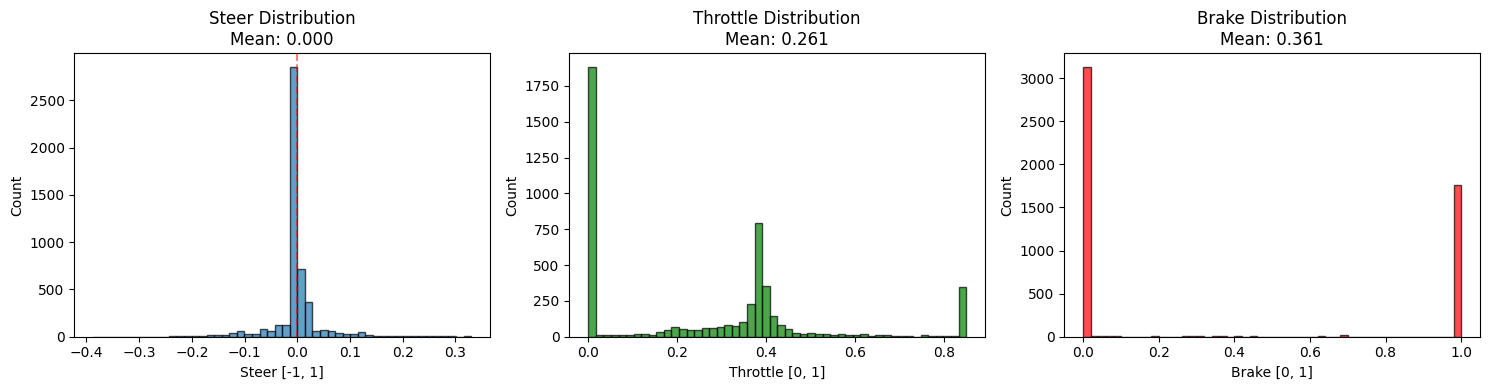

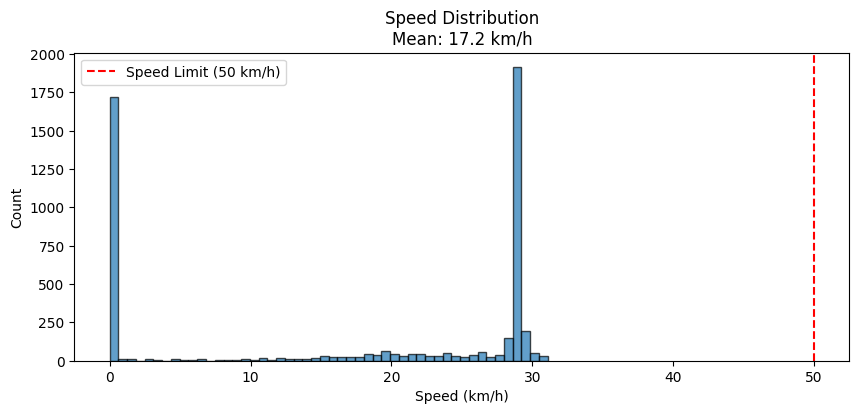

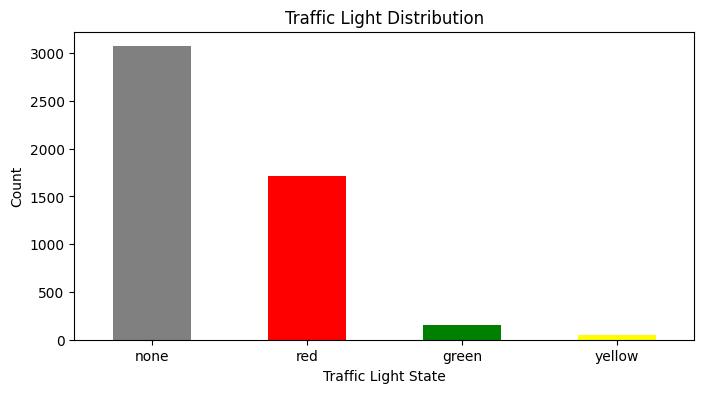

In [9]:
# Cell 9: 액션 분포 분석

if episode_dirs:
    # 모든 에피소드 데이터 합치기
    all_frames = []
    for ep_dir in episode_dirs[:5]:  # 처음 5개만
        df = pd.read_parquet(Path(ep_dir) / 'frames.parquet')
        all_frames.append(df)
    
    combined_df = pd.concat(all_frames, ignore_index=True)
    
    # 액션 분포
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Steer
    axes[0].hist(combined_df['steer'], bins=50, alpha=0.7, edgecolor='black')
    axes[0].set_xlabel('Steer [-1, 1]')
    axes[0].set_ylabel('Count')
    axes[0].set_title(f'Steer Distribution\nMean: {combined_df["steer"].mean():.3f}')
    axes[0].axvline(0, color='red', linestyle='--', alpha=0.5)
    
    # Throttle
    axes[1].hist(combined_df['throttle'], bins=50, alpha=0.7, edgecolor='black', color='green')
    axes[1].set_xlabel('Throttle [0, 1]')
    axes[1].set_ylabel('Count')
    axes[1].set_title(f'Throttle Distribution\nMean: {combined_df["throttle"].mean():.3f}')
    
    # Brake
    axes[2].hist(combined_df['brake'], bins=50, alpha=0.7, edgecolor='black', color='red')
    axes[2].set_xlabel('Brake [0, 1]')
    axes[2].set_ylabel('Count')
    axes[2].set_title(f'Brake Distribution\nMean: {combined_df["brake"].mean():.3f}')
    
    plt.tight_layout()
    plt.show()
    
    # 속도 분포
    plt.figure(figsize=(10, 4))
    plt.hist(combined_df['ego_speed'] * 3.6, bins=50, alpha=0.7, edgecolor='black')
    plt.xlabel('Speed (km/h)')
    plt.ylabel('Count')
    plt.title(f'Speed Distribution\nMean: {combined_df["ego_speed"].mean() * 3.6:.1f} km/h')
    plt.axvline(50, color='red', linestyle='--', label='Speed Limit (50 km/h)')
    plt.legend()
    plt.show()
    
    # 신호등 상태 분포
    plt.figure(figsize=(8, 4))
    tl_counts = combined_df['traffic_light'].value_counts()
    colors = {'none': 'gray', 'green': 'green', 'yellow': 'yellow', 'red': 'red'}
    tl_counts.plot(kind='bar', color=[colors.get(x, 'blue') for x in tl_counts.index])
    plt.xlabel('Traffic Light State')
    plt.ylabel('Count')
    plt.title('Traffic Light Distribution')
    plt.xticks(rotation=0)
    plt.show()

In [ ]:
# Cell 10: 데이터 저장 요약

# 전체 데이터셋 정보 저장
dataset_info = {
    'num_episodes': len(episode_dirs),
    'total_frames': total_frames,
    'total_collisions': total_collisions,
    'total_lane_invasions': total_lane_invasions,
    'sensor_config': SENSOR_CONFIG,
    'collection_date': datetime.now().isoformat(),
    'carla_version': '0.9.15'
}

with open(SAVE_DIR / 'dataset_info.json', 'w') as f:
    json.dump(dataset_info, f, indent=2)

print("=" * 50)
print("데이터 수집 완료 요약")
print("=" * 50)
print(f"저장 위치: {SAVE_DIR}")
print(f"에피소드 수: {len(episode_dirs)}")
print(f"총 프레임: {total_frames:,}")
print(f"\n다음 단계: 03_kitti_exploration.ipynb")

데이터 수집 완료 요약
저장 위치: c:\git\automotive\dataset\carla_collected
에피소드 수: 14
총 프레임: 14,000

다음 단계: 03_kitti_exploration.ipynb


: 

## 수집 데이터 구조

```
dataset/carla_collected/
├── dataset_info.json          # 전체 데이터셋 정보
├── episode_000/
│   ├── metadata.json          # 에피소드 메타데이터
│   ├── frames.parquet         # 프레임별 데이터
│   └── images/
│       ├── 000000.jpg
│       ├── 000001.jpg
│       └── ...
├── episode_001/
│   └── ...
└── ...
```

## 참고 논문

| 논문 | 핵심 아이디어 |
|------|---------------|
| CARLA (Dosovitskiy et al., 2017) | 자율주행 시뮬레이터, 다양한 센서 및 환경 조건 제공 |
| End-to-End Learning (Bojarski et al., 2016) | CNN으로 이미지→조향 직접 학습, NVIDIA PilotNet |
| DAgger (Ross et al., 2011) | Dataset Aggregation, 분포 불일치 해결 |